In [1]:
%matplotlib inline
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import imageio

log_path = pathlib.Path('log/kubric_chair_v2/tune/chair_no_viewdir_no_far_sigma_s/001_best/renders-runtime/00100000/runtime_eval/model_out')
files = list(sorted(log_path.glob('*.npy')))
np.set_printoptions(suppress=True)
ID = 1
OUT = np.load(str(files[ID]), allow_pickle=True).item()

for k in OUT.keys():
    OUT[k] = OUT[k].astype(np.float32)
    
z_vals = OUT['z_vals']
dirs = OUT['dirs']
sigma_d = OUT['sigma_d']
sigma_s = OUT['sigma_s']
eps=1e-10

##########################
sample_at_infinity = False
##########################

last_sample_z = 1e10 if sample_at_infinity else 1e-19
dists = np.concatenate([ # distance between each sample along a ray
  z_vals[..., 1:] - z_vals[..., :-1],
  np.broadcast_to([last_sample_z], z_vals[..., :1].shape)
], -1)
dists = dists * np.linalg.norm(dirs[..., None, :], axis=-1)

if sample_at_infinity:
    # dynamic component should not use the last sample located at infinite far away plane
    # this allows rays on empty dynamic component to not terminate 
    dists_d = np.concatenate([ 
        z_vals[..., 1:] - z_vals[..., :-1],
        np.broadcast_to([1e-19], z_vals[..., :1].shape)
    ], -1)
    dists_d = dists_d * np.linalg.norm(dirs[..., None, :], axis=-1)
else:
    dists_d = dists

alpha_d = (1.0 - np.exp(-sigma_d * dists_d))
alpha_s = (1.0 - np.exp(-sigma_s * dists))
alpha_both = (1.0 - np.exp(-(sigma_d * dists_d + sigma_s * dists)))
# Prepend a 1.0 to make this an 'exclusive' cumprod as in `tf.math.cumprod`.
Ts = np.concatenate([
  np.ones_like(alpha_both[..., :1], alpha_both.dtype),
  np.cumprod(1.0 - alpha_both[..., :-1] + eps, axis=-1),
], axis=-1)

weights_d = alpha_d * Ts
weights_s = alpha_s * Ts
print(OUT.keys())
files

dict_keys(['acc', 'blendw', 'depth', 'dirs', 'dists', 'extra_rgb_blendw', 'extra_rgb_dynamic', 'extra_rgb_mask', 'extra_rgb_static', 'med_depth', 'med_points', 'rgb', 'rgb_blendw', 'sigma_d', 'sigma_s', 'z_vals'])


[PosixPath('log/kubric_chair_v2/tune/chair_no_viewdir_no_far_sigma_s/001_best/renders-runtime/00100000/runtime_eval/model_out/rgba_00000.npy'),
 PosixPath('log/kubric_chair_v2/tune/chair_no_viewdir_no_far_sigma_s/001_best/renders-runtime/00100000/runtime_eval/model_out/rgba_00049.npy'),
 PosixPath('log/kubric_chair_v2/tune/chair_no_viewdir_no_far_sigma_s/001_best/renders-runtime/00100000/runtime_eval/model_out/rgba_00099.npy'),
 PosixPath('log/kubric_chair_v2/tune/chair_no_viewdir_no_far_sigma_s/001_best/renders-runtime/00100000/runtime_eval/model_out/rgba_00149.npy'),
 PosixPath('log/kubric_chair_v2/tune/chair_no_viewdir_no_far_sigma_s/001_best/renders-runtime/00100000/runtime_eval/model_out/rgba_00199.npy')]

In [15]:
k=20
0.5 ** (1/k)

0.9659363289248456

<IPython.core.display.Javascript object>


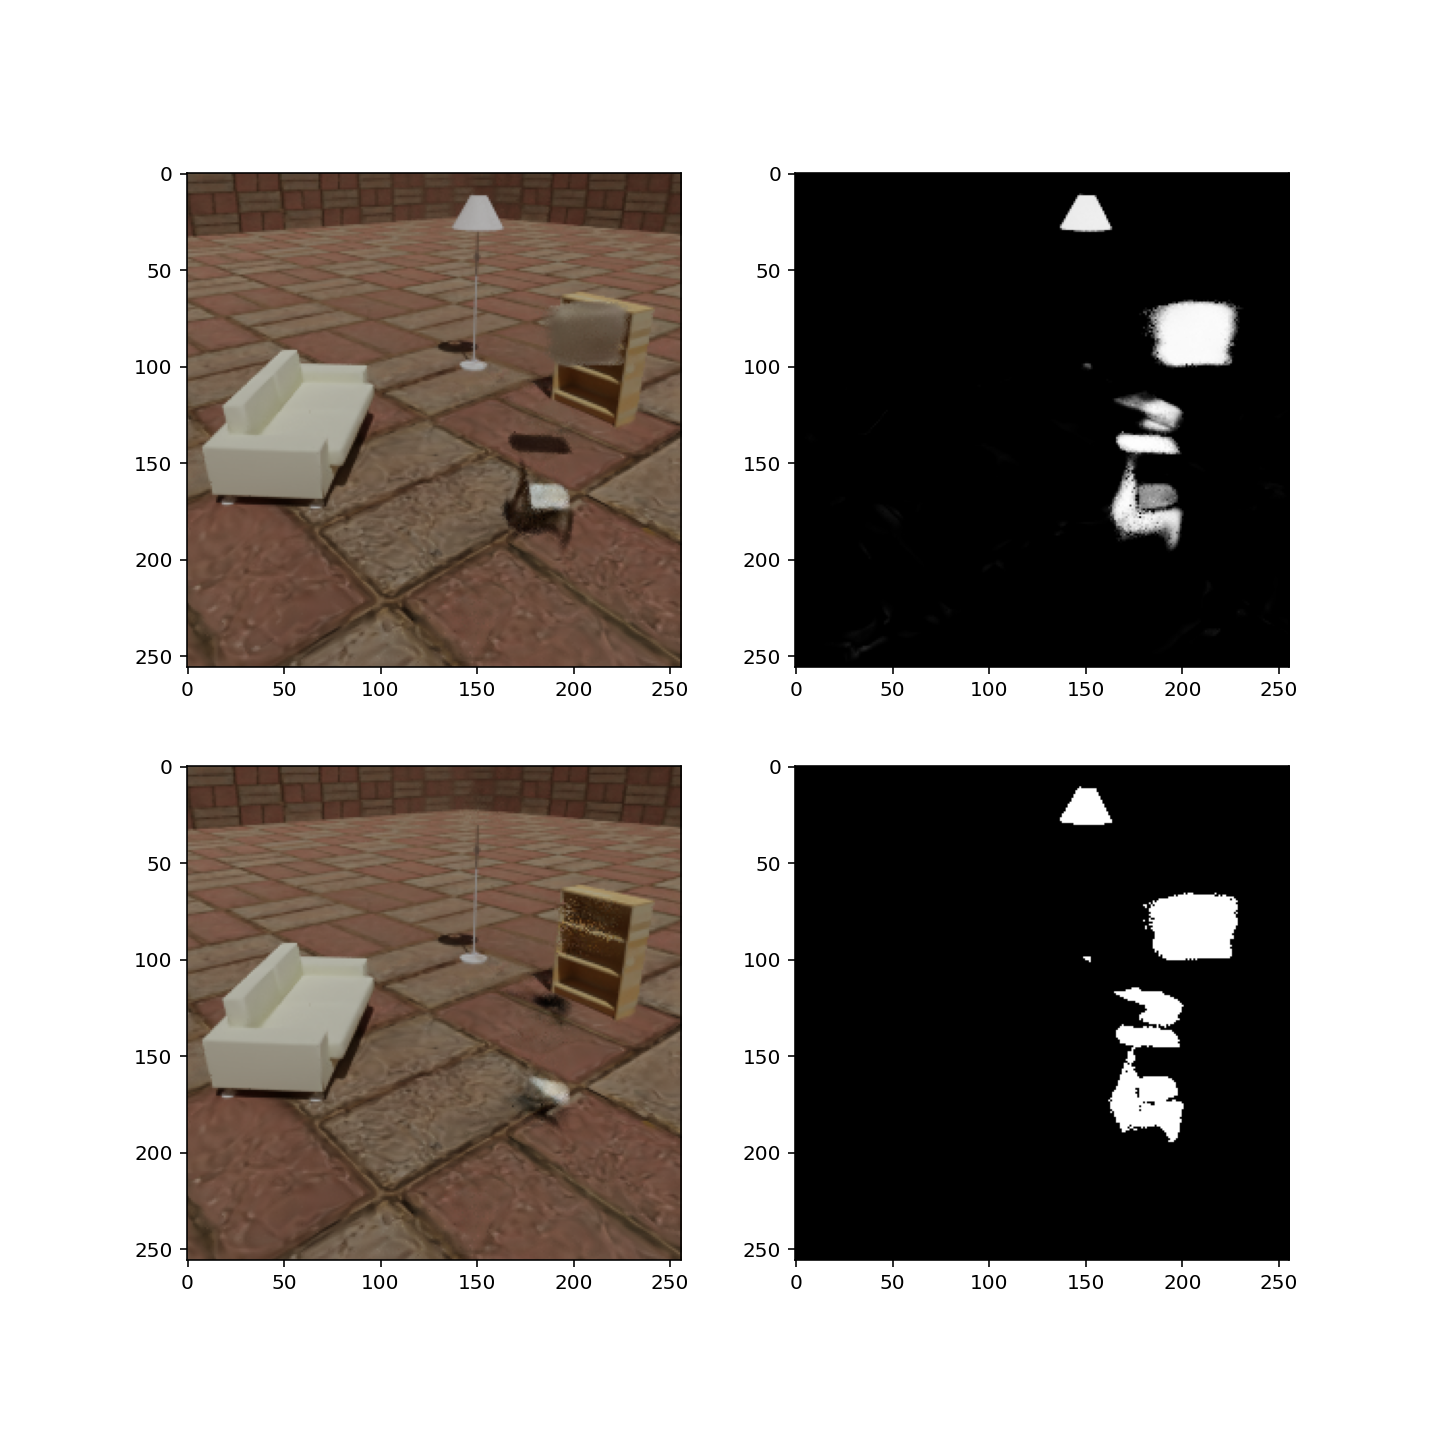

In [6]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,10]
fig, ax = plt.subplots(nrows=2, ncols=2)

k = 5.

ax[0,0].imshow(OUT['rgb'])
ax[0,1].imshow(OUT['extra_rgb_blendw'])
ax[1,0].imshow(OUT['extra_rgb_static'])
# ax[1,1].imshow(OUT['extra_rgb_mask'])
# ax[1,1].imshow(np.where(OUT['extra_rgb_blendw'] > (0.5 ** (1/k)), 1., 0.))
ax[1,1].imshow(np.where(OUT['extra_rgb_blendw'] > 0.15, 1., 0.))
plt.show()

In [7]:
# Note that pixel is obtained by rgb[y,x]
x, y = [118,191]
OUT['extra_rgb_blendw'][y,x]

array([0.00207901, 0.00207901, 0.00207901], dtype=float32)

In [36]:
OUT['blendw'][y,x]

array([0.00000441, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00017786, 0.00762939,
       0.01181793, 0.01416779, 0.0168457 , 0.02346802, 0.02488708,
       0.02365112, 0.02372742, 0.02355957, 0.02415466, 0.02528381,
       0.0269165 , 0.02696228, 0.02871704, 0.03149414, 0.03161621,
       0.03128052, 0.03045654, 0.0168457 , 0.01704407, 0.0191803 ,
       0.0201416 , 0.02056885, 0.02288818, 0.02516174, 0.02565002,
       0.0267334 , 0.02737427, 0.02857971, 0.02819824, 0.02812195,
       0.02755737, 0.02539062, 0.0246582 , 0.02529907, 0.02630615,
       0.02861023, 0.02932739, 0.02912903, 0.0294342 , 0.03051758,
       0.03637695, 0.04711914, 0.04891968, 0.05871582, 0.059021  ,
       0.06591797, 0.07263184, 0.07611084, 0.08172607, 0.08502197,
       0.08728027, 0.09594727, 0.10534668, 0.10650635, 0.12286

In [8]:
weights_s[y,x]

array([0.00000062, 0.00000014, 0.0000008 , 0.00000873, 0.00003741,
       0.00004573, 0.00009706, 0.00001232, 0.00002514, 0.00007116,
       0.00004517, 0.00001762, 0.00002028, 0.00002343, 0.00002426,
       0.00002855, 0.00047339, 0.00018011, 0.0001444 , 0.00008826,
       0.00019696, 0.0007166 , 0.00092995, 0.00039862, 0.00104925,
       0.00158554, 0.00112598, 0.00123909, 0.00296562, 0.        ,
       0.00591964, 0.02101868, 0.00755366, 0.00880011, 0.03838866,
       0.02689845, 0.01431045, 0.01501162, 0.04665743, 0.03524285,
       0.        , 0.05534643, 0.01945679, 0.09270552, 0.01840322,
       0.03500738, 0.        , 0.10122749, 0.01087964, 0.0553656 ,
       0.05160463, 0.01567256, 0.00511134, 0.        , 0.02232565,
       0.00646453, 0.01729186, 0.10417868, 0.00349158, 0.00676807,
       0.01908063, 0.01855845, 0.01004037, 0.00314896, 0.00454254,
       0.01736717, 0.02668112, 0.00184125, 0.00612078, 0.02355471,
       0.01399341, 0.00047171, 0.00004744, 0.        , 0.     

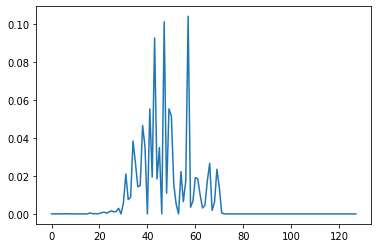

In [9]:
%matplotlib inline
plt.plot(weights_s[y,x])

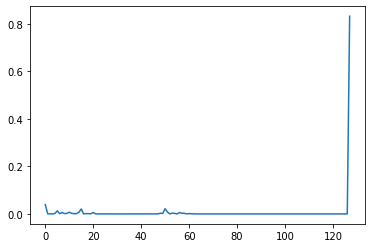

In [56]:
%matplotlib inline
x, y = [163,72] # [109,73]
plt.plot(weights_s[y,x])

In [30]:
sigma_s[y,x]

array([ 1.0449219 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00000089,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 15.7109375 , 17.21875   ,
       18.546875  , 18.        , 20.453125  , 21.5       , 22.40625   ,
       22.625     , 24.09375   , 24.75      , 25.21875   , 25.171875  ,
       26.15625   , 26.484375  , 28.        , 27.328125  , 26.796875  ,
       26.859375  , 25.6875    , 25.        , 21.484375  , 24.484375  ,
       22.859375  , 23.015625  , 23.125     , 23.3125    , 23.578125  ,
       31.375     , 32.78125   , 36.21875   , 28.921875  , 28.15625   ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [7]:
sigma_s[y,x]

array([ 4.53125   ,  4.8554688 ,  6.5585938 ,  8.1015625 ,  8.1484375 ,
        8.546875  ,  9.59375   ,  9.7578125 , 11.4453125 , 12.9921875 ,
       12.9609375 ,  7.1054688 ,  5.7070312 ,  4.5234375 ,  4.3632812 ,
        2.9355469 ,  2.9375    ,  1.9609375 ,  1.9541016 ,  2.0527344 ,
        2.2480469 ,  0.7236328 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00004536,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00001317,  0.0000053 ,  0.0000003 ,
        0.0000003 ,  0.00035691,  0.16772461,  0.18310547,  0.15771484,
        0.18701172,  0.23352051,  0.26000977,  0.11322021,  0.14501953,
        0.29296875,  0.36328125,  0.37841797,  0.38476562,  0.40551758,
        0.3527832 ,  0.31713867,  0.18530273,  0.18603516,  0.15881348,
        0.15649414,  0.15661621,  0.10430908,  0.03927612,  0.02

In [27]:
sigma_s_sum = np.sum(sigma_s, -1, keepdims=True) 
mask = np.where(sigma_s_sum < 0.1, 0., 1.) 

alpha = 1. - np.exp(- sigma_s * dists)
# prevent nan
alpha = np.clip(alpha, a_min=1e-19, a_max=100)
p = alpha / np.sum(alpha, -1, keepdims=True) 

entropy = mask * -np.mean(p * np.log(p), -1, keepdims=True) # change from sum to mean to make scale of number more comparable
entropy

array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.00468696],
        [0.00511867],
        [0.00483831],
        ...,
        [0.00428863],
        [0.00433655],
        [0.00332132]],

       [[0.00493739],
        [0.00417   ],
        [0.00588451],
        ...,
        [0.00301789],
        [0.00403949],
        [0.00391033]],

       [[0.00388893],
        [0.00565316],
        [0.00669482],
        ...,
        [0.00399902],
        [0.0039816 ],
        [0.00355894]]])

In [21]:
entropy.shape

(256, 256, 1)

<IPython.core.display.Javascript object>


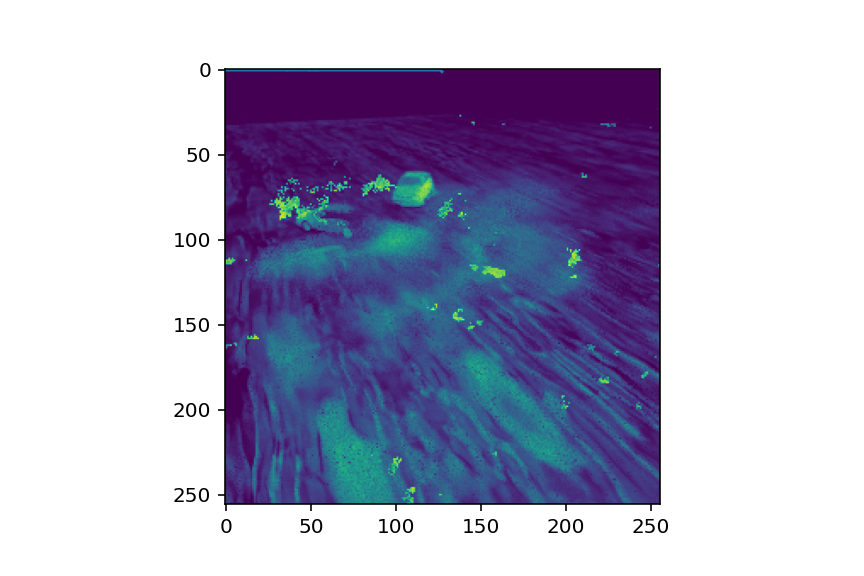

In [28]:

%matplotlib notebook
plt.imshow(entropy)

In [15]:
sigma_s

array([[[0.        , 0.        , 0.        , ..., 0.00000006,
         0.00000006, 0.00000036],
        [0.        , 0.        , 0.        , ..., 0.00000018,
         0.00000006, 0.00000048],
        [0.        , 0.        , 0.        , ..., 0.00000006,
         0.00000006, 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00000036,
         0.00000012, 0.00000006],
        [0.        , 0.        , 0.        , ..., 0.00000054,
         0.00000024, 0.0000003 ],
        [0.        , 0.        , 0.        , ..., 0.00000411,
         0.00000042, 0.00000149]],

       [[0.        , 0.        , 0.        , ..., 0.00000417,
         0.00000072, 0.00000286],
        [0.        , 0.        , 0.        , ..., 0.00000083,
         0.0000006 , 0.0000006 ],
        [0.        , 0.        , 0.        , ..., 0.00000018,
         0.00000012, 0.00000024],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00000054,
         0.00000036, 0.        ],
        [0. 

In [22]:
weights_s[y,x]

array([0.04877391, 0.03918455, 0.0129147 , 0.07997642, 0.04047189,
       0.00306044, 0.02759218, 0.01877199, 0.19902604, 0.10648332,
       0.00242329, 0.00010272, 0.00009994, 0.00029739, 0.00195246,
       0.0005732 , 0.00016011, 0.00015733, 0.00019122, 0.00022392,
       0.00005292, 0.00000937, 0.00014832, 0.        , 0.00007428,
       0.00001546, 0.00004819, 0.00015179, 0.00005359, 0.00070836,
       0.00008235, 0.00011784, 0.0000082 , 0.0000221 , 0.00007961,
       0.00028868, 0.0001135 , 0.00000516, 0.00002598, 0.00007925,
       0.00002689, 0.00001294, 0.        , 0.00000906, 0.00001471,
       0.00002234, 0.00000646, 0.0000662 , 0.00005466, 0.00017242,
       0.00099374, 0.00068778, 0.00154703, 0.00565593, 0.0087309 ,
       0.0050054 , 0.03313192, 0.01722228, 0.0080248 , 0.00382399,
       0.02148911, 0.00296031, 0.01923241, 0.01996614, 0.        ,
       0.02486828, 0.00141986, 0.00006963, 0.00056927, 0.00059766,
       0.00320632, 0.00008034, 0.00014838, 0.00092461, 0.00735

In [20]:
alpha_d[y,x] / np.clip(alpha_d[y,x] + alpha_s[y,x], 1e-19, 100)

array([0.17095452, 0.11490507, 0.1152431 , 0.09016063, 0.09254491,
       0.        , 0.09145926, 0.09532651, 0.14044321, 0.17034511,
       0.16626578, 0.16696247, 0.16724906, 0.16570325, 0.1648698 ,
       0.16591065, 0.16204107, 0.16212699, 0.16378512, 0.16101915,
       0.17129864, 0.17332868, 0.17825038, 0.18900058, 0.19204617,
       0.17204816, 0.16560188, 0.16348414, 0.14148593, 0.14394097,
       0.13458801, 0.13337098, 0.1195567 , 0.11576225, 0.11000036,
       0.10950795, 0.11276414, 0.10754418, 0.1086118 , 0.10686231,
       0.10810257, 0.10195773, 0.        , 0.10256976, 0.10385342,
       0.        , 0.10626587, 0.11329025, 0.11394685, 0.11450694,
       0.11541297, 0.12353417, 0.14126237, 0.11697963, 0.11650834,
       0.11878765, 0.12362899, 0.09876343, 0.08056608, 0.07036384,
       0.06828672, 0.06994998, 0.05974042, 0.0591484 , 0.05030126,
       0.03654791, 0.03537327, 0.03587372, 0.03643512, 0.03705303,
       0.03828994, 0.04030844, 0.0374424 , 0.02896313, 0.02779

In [18]:
OUT['sigma_s'][y,x]

array([ 5.18  ,  7.555 ,  7.6   ,  9.64  , 10.23  , 11.12  , 11.12  ,
       13.88  ,  9.62  ,  8.1   ,  8.5   ,  8.57  ,  8.62  ,  8.77  ,
        8.87  ,  8.88  ,  9.02  ,  9.016 ,  9.01  ,  9.02  ,  8.59  ,
        8.52  ,  8.33  ,  8.09  ,  8.1   ,  9.7   , 10.336 , 10.78  ,
       12.7   , 12.46  , 12.7   , 12.37  , 13.16  , 13.63  , 14.445 ,
       14.54  , 14.61  , 14.9   , 14.94  , 15.31  , 15.375 , 16.8   ,
       16.81  , 16.83  , 16.97  , 17.17  , 17.2   , 17.33  , 17.97  ,
       18.27  , 18.42  , 18.5   , 18.62  , 20.14  , 19.28  , 18.86  ,
       18.39  , 20.61  , 20.27  , 21.95  , 21.31  , 21.03  , 22.75  ,
       22.03  , 23.44  , 26.4   , 26.12  , 25.97  , 25.34  , 24.9   ,
       24.83  , 23.9   , 25.16  , 26.64  , 26.34  , 26.31  , 20.98  ,
       20.77  , 22.58  , 22.47  , 17.98  , 23.34  , 11.48  ,  2.275 ,
        6.555 ,  5.305 ,  1.203 ,  0.749 ,  0.619 ,  0.7124,  0.4985,
        0.407 ,  0.6846,  0.522 ,  0.3403,  0.668 ,  0.628 ,  0.7524,
        0.753 ,  0.8

In [19]:
OUT['sigma_d'][y,x]

array([1.054     , 0.98      , 0.977     , 0.947     , 1.037     ,
       1.083     , 1.087     , 1.437     , 1.547     , 1.652     ,
       1.685     , 1.715     , 1.726     , 1.737     , 1.749     ,
       1.754     , 1.744     , 1.742     , 1.733     , 1.719     ,
       1.773     , 1.778     , 1.79      , 1.877     , 1.903     ,
       2.008     , 2.041     , 2.068     , 2.059     , 2.04      ,
       1.951     , 1.878     , 1.775     , 1.762     , 1.781     ,
       1.785     , 1.786     , 1.791     , 1.8       , 1.829     ,
       1.83      , 1.905     , 1.908     , 1.911     , 1.952     ,
       1.991     , 1.995     , 2.186     , 2.291     , 2.344     ,
       2.396     , 2.428     , 2.895     , 2.59      , 2.512     ,
       2.492     , 2.426     , 2.15      , 1.725     , 1.621     ,
       1.551     , 1.53      , 1.412     , 1.317     , 1.167     ,
       0.9863    , 0.955     , 0.9517    , 0.9526    , 0.9556    ,
       0.9575    , 0.9604    , 0.8813    , 0.7725    , 0.746  

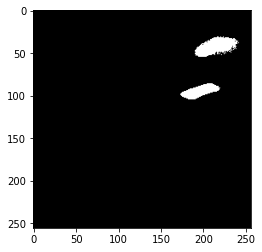

In [31]:
%matplotlib inline
plt.imshow(np.where(OUT['extra_rgb_blendw'] > 0.25, 1., 0.) )

<IPython.core.display.Javascript object>


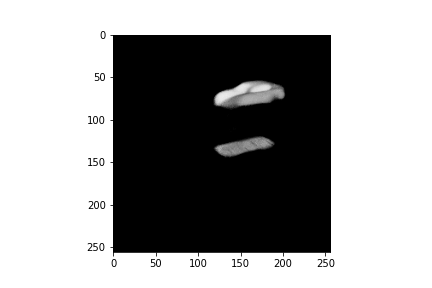

In [2]:
img = imageio.imread('log/kubric_single_car_rand/tune/small_skewness_2_gt/003_best_dynamic/renders-runtime/00050000/runtime_eval/runtime_eval/blendw_rgb_rgba_00049.png')
img = img / 255

%matplotlib notebook
plt.imshow(img)


In [4]:
from hypernerf import schedules
ws1_sched = schedules.ExpIncreaseSchedule(1e-05, 0.1, 250000)
ws2_sched = schedules.ExpIncreaseSchedule(1e-05, 1.0, 250000)

xs = [i for i in range(1, 250000, 100)]
ws1 = [ws1_sched(x) for x in xs]
ws2 = [ws2_sched(x) for x in xs]

In [26]:
config = {
  'type': 'piecewise',
  'schedules': [
    (50000, ('constant', 0.0)),
    (0, ('linear', 0.0, 0.1, 50000))
  ],
}
sched = schedules.from_config(config)
sched(100000)

DeviceArray(0.1, dtype=float32)

In [25]:
sched.schedules[1].final_value

0.1

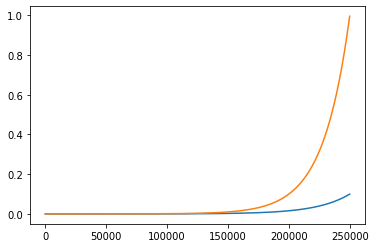

In [5]:
%matplotlib inline
plt.plot(xs,ws1)
plt.plot(xs,ws2)

In [42]:
ws2_sched(100000)

DeviceArray(0.1, dtype=float32)

In [46]:
ws1_sched(100000)

DeviceArray(0.01, dtype=float32)

In [67]:
ws1

[0.010000307020152244,
 0.010031056685635496,
 0.010061900902408567,
 0.010092839961204582,
 0.010123874153650637,
 0.010155003772270542,
 0.01018622911048758,
 0.010217550462627276,
 0.010248968123920163,
 0.010280482390504577,
 0.010312093559429436,
 0.010343801928657047,
 0.010375607797065914,
 0.010407511464453552,
 0.010439513231539316,
 0.01047161339996724,
 0.010503812272308864,
 0.010536110152066106,
 0.010568507343674108,
 0.010601004152504114,
 0.01063360088486635,
 0.010666297848012894,
 0.010699095350140598,
 0.010731993700393972,
 0.010764993208868107,
 0.010798094186611602,
 0.010831296945629485,
 0.010864601798886162,
 0.010898009060308361,
 0.010931519044788101,
 0.010965132068185649,
 0.010998848447332501,
 0.011032668500034376,
 0.011066592545074194,
 0.011100620902215103,
 0.011134753892203475,
 0.01116899183677194,
 0.01120333505864241,
 0.01123778388152913,
 0.011272338630141723,
 0.011306999630188252,
 0.011341767208378291,
 0.011376641692426007,
 0.01141162341105